In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import h5py
import os

import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
file_path = '/home/zilong/Desktop/MattiasDataAnalysis/Data/proc_ca1_2022-10-04_10-46-27_d_experiment1.mat'
# file_path = '/home/zilong/Desktop/MattiasDataAnalysis/Data/proc_right_2022-12-20_11-08-22_m16_experiment1.mat'
with h5py.File(file_path, 'r') as f:
    # List all top-level keys
    print(list(f.keys()))
    # Access the data
    spiketimes = f['npx']['spk']['times'][:].flatten()
    cellspikeid = f['npx']['spk']['cluID'][:].flatten()
    position_times = f['npx']['pos']['times'][:].flatten()
    position_xy = f['npx']['pos']['xy'][:]
    reward_location = f['npx']['pos']['vr']['RewardConsumed']['Data'][:]
    reward_time = f['npx']['pos']['vr']['RewardConsumed']['TimeStamps'][:]
    
    
#calculate speed
pos_sample_rate = 1./np.mean(np.diff(position_times))
position = position_xy.T
#calculate speed
speed = utils.compute_speed(position[:, 0], position[:, 1], position_times)

start = (position_xy[0,:].max() - position_xy[1,:].max())/2
#remove data points when x < start and x > position_square[0,:].max()-start
index = np.where((position_xy[0,:] > start) & (position_xy[0,:] < position_xy[0,:].max()-start))[0]

position_filtered = position_xy[:, index]
#sutract position_filtered[0,:].min from position_filtered[0,:]
position_filtered[0, :] = position_filtered[0, :] - position_filtered[0, :].min() 
speed_filtered = speed[index]
position_times_filtered = position_times[index]

#calculate spike arrays
SpikeArrays = np.zeros((len(np.unique(cellspikeid)), len(position_times.flatten())))

for i, id in enumerate(np.unique(cellspikeid)):
    idx = np.where(cellspikeid == id)[0]
    #get the spike times of idx
    spike_times_i = spiketimes[idx]
    spike_array_i = utils.compute_spike_array(spike_times_i, position_times)
    SpikeArrays[i, :] = spike_array_i
    
SpikeArrays_filered = SpikeArrays[:, index]
summed_SpikeArray_filtered = np.sum(SpikeArrays_filered, axis=0)




['#refs#', '#subsystem#', 'npx']


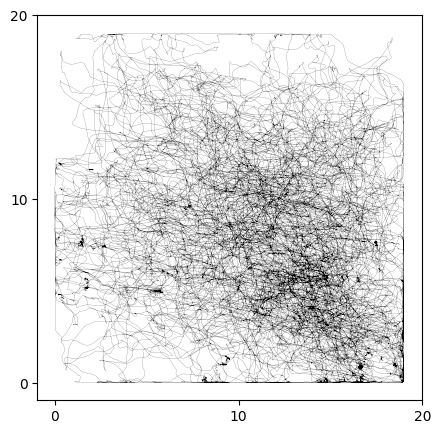

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(position_filtered[0,:], position_filtered[1,:], color='k', lw=0.1)
#equal axis
ax.set_aspect('equal')
#xticks and yticks
ax.set_xticks([0,10, 20])
ax.set_yticks([0,10, 20])



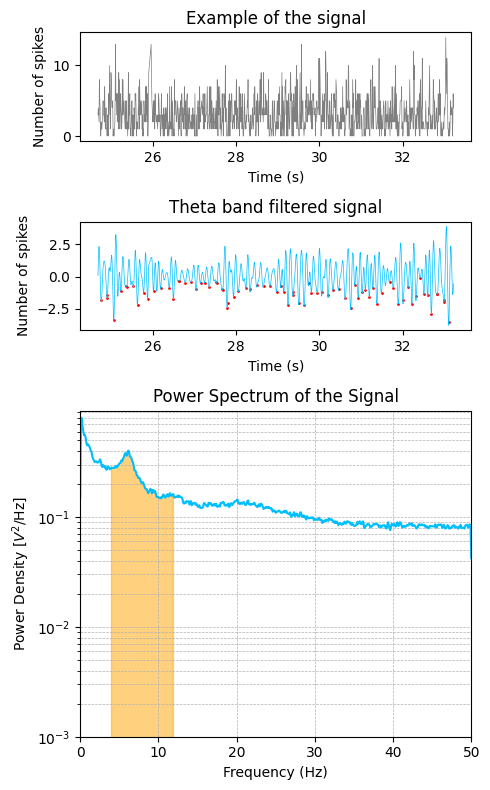

In [5]:

#plot example period of the signal and power spectrum
fig, axs = plt.subplots(3,1, figsize=(5,8), dpi=100, height_ratios=[1, 1, 3])

T=1000
axs[0].plot(position_times[:T], summed_SpikeArray_filtered[:T], color='black', linewidth=0.5, alpha=0.5)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Number of spikes')
axs[0].set_title('Example of the signal')

lfp_filtered = utils.bandpassfilter(summed_SpikeArray_filtered, lowcut=6, highcut=12, fs=100)
#plot the example filtered signal and the power spectrum
axs[1].plot(position_times[:T], lfp_filtered[:T], color='deepskyblue', linewidth=0.5, alpha=1)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Number of spikes')
axs[1].set_title('Theta band filtered signal')
phase = utils.get_phase(lfp_filtered[:T])
#plot if phase <0.5 as red dot
axs[1].scatter(position_times[:T][phase<0.5], lfp_filtered[:T][phase<0.5], color='red', s=1)

# Define the theta band range
theta_range = (4, 12)  # Theta band (Hz)

# Compute the power spectrum using Welch's method
frequencies, power_spectrum = welch(summed_SpikeArray_filtered, fs=100, nperseg=1024)

# Plot the power spectrum
axs[2].semilogy(frequencies, power_spectrum,color='deepskyblue')  # Plot on a log scale for better visibility
axs[2].set_xlim(0, 50)  # Adjust x-axis limits to focus on lower frequencies
axs[2].set_ylim(bottom=1e-3)  # Adjust y-axis limits to avoid taking the log of zero

axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel(r'Power Density [$V^2$/Hz]')
axs[2].set_title('Power Spectrum of the Signal')

# Highlight the theta frequency band
axs[2].fill_between(frequencies, power_spectrum, where=(frequencies >= theta_range[0]) & (frequencies <= theta_range[1]), color='orange', alpha=0.5)

axs[2].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()




    

## decode internal position

In [6]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification import Environment, RandomWalk, estimate_movement_var
from scipy.ndimage import gaussian_filter1d
import xarray as xr

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
pos_sample_rate = 1./np.mean(np.diff(position_times))
position = position_filtered.T
print(position.shape)
movement_var = estimate_movement_var(position, pos_sample_rate)
environment = Environment(place_bin_size=1)
# transition_type = RandomWalk(movement_var=np.sqrt(movement_var[0,0]))
transition_type = RandomWalk(movement_var=3)
decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
    sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
    sorted_spikes_algorithm_params={'block_size': None,
                                    'position_std': 1,
                                    'use_diffusion': False,},
)

speed_thres = 0.5 # unit/s in VR
is_training = speed_filtered > speed_thres
decoder.fit(position, SpikeArrays_filered.T, is_training=is_training)



/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/replay_trajectory_classification/continuous_state_transitions.py:24: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)


  0%|          | 0/196 [00:00<?, ?it/s]

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:117: RuntimeWarning: divide by zero encountered in log
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)
/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/replay_trajectory_classification/likelihoods/spiking_likelihood_kde_gpu.py:117: RuntimeWarning: invalid value encountered in subtract
  np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy)


SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=1, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde_gpu',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 1,
                                                    'use_diffusion': False},
                    transition_type=RandomWalk(environment_name='', movement_var=3, movement_mean=0.0, use_diffusion=False))

## plot all firing fields of all cells

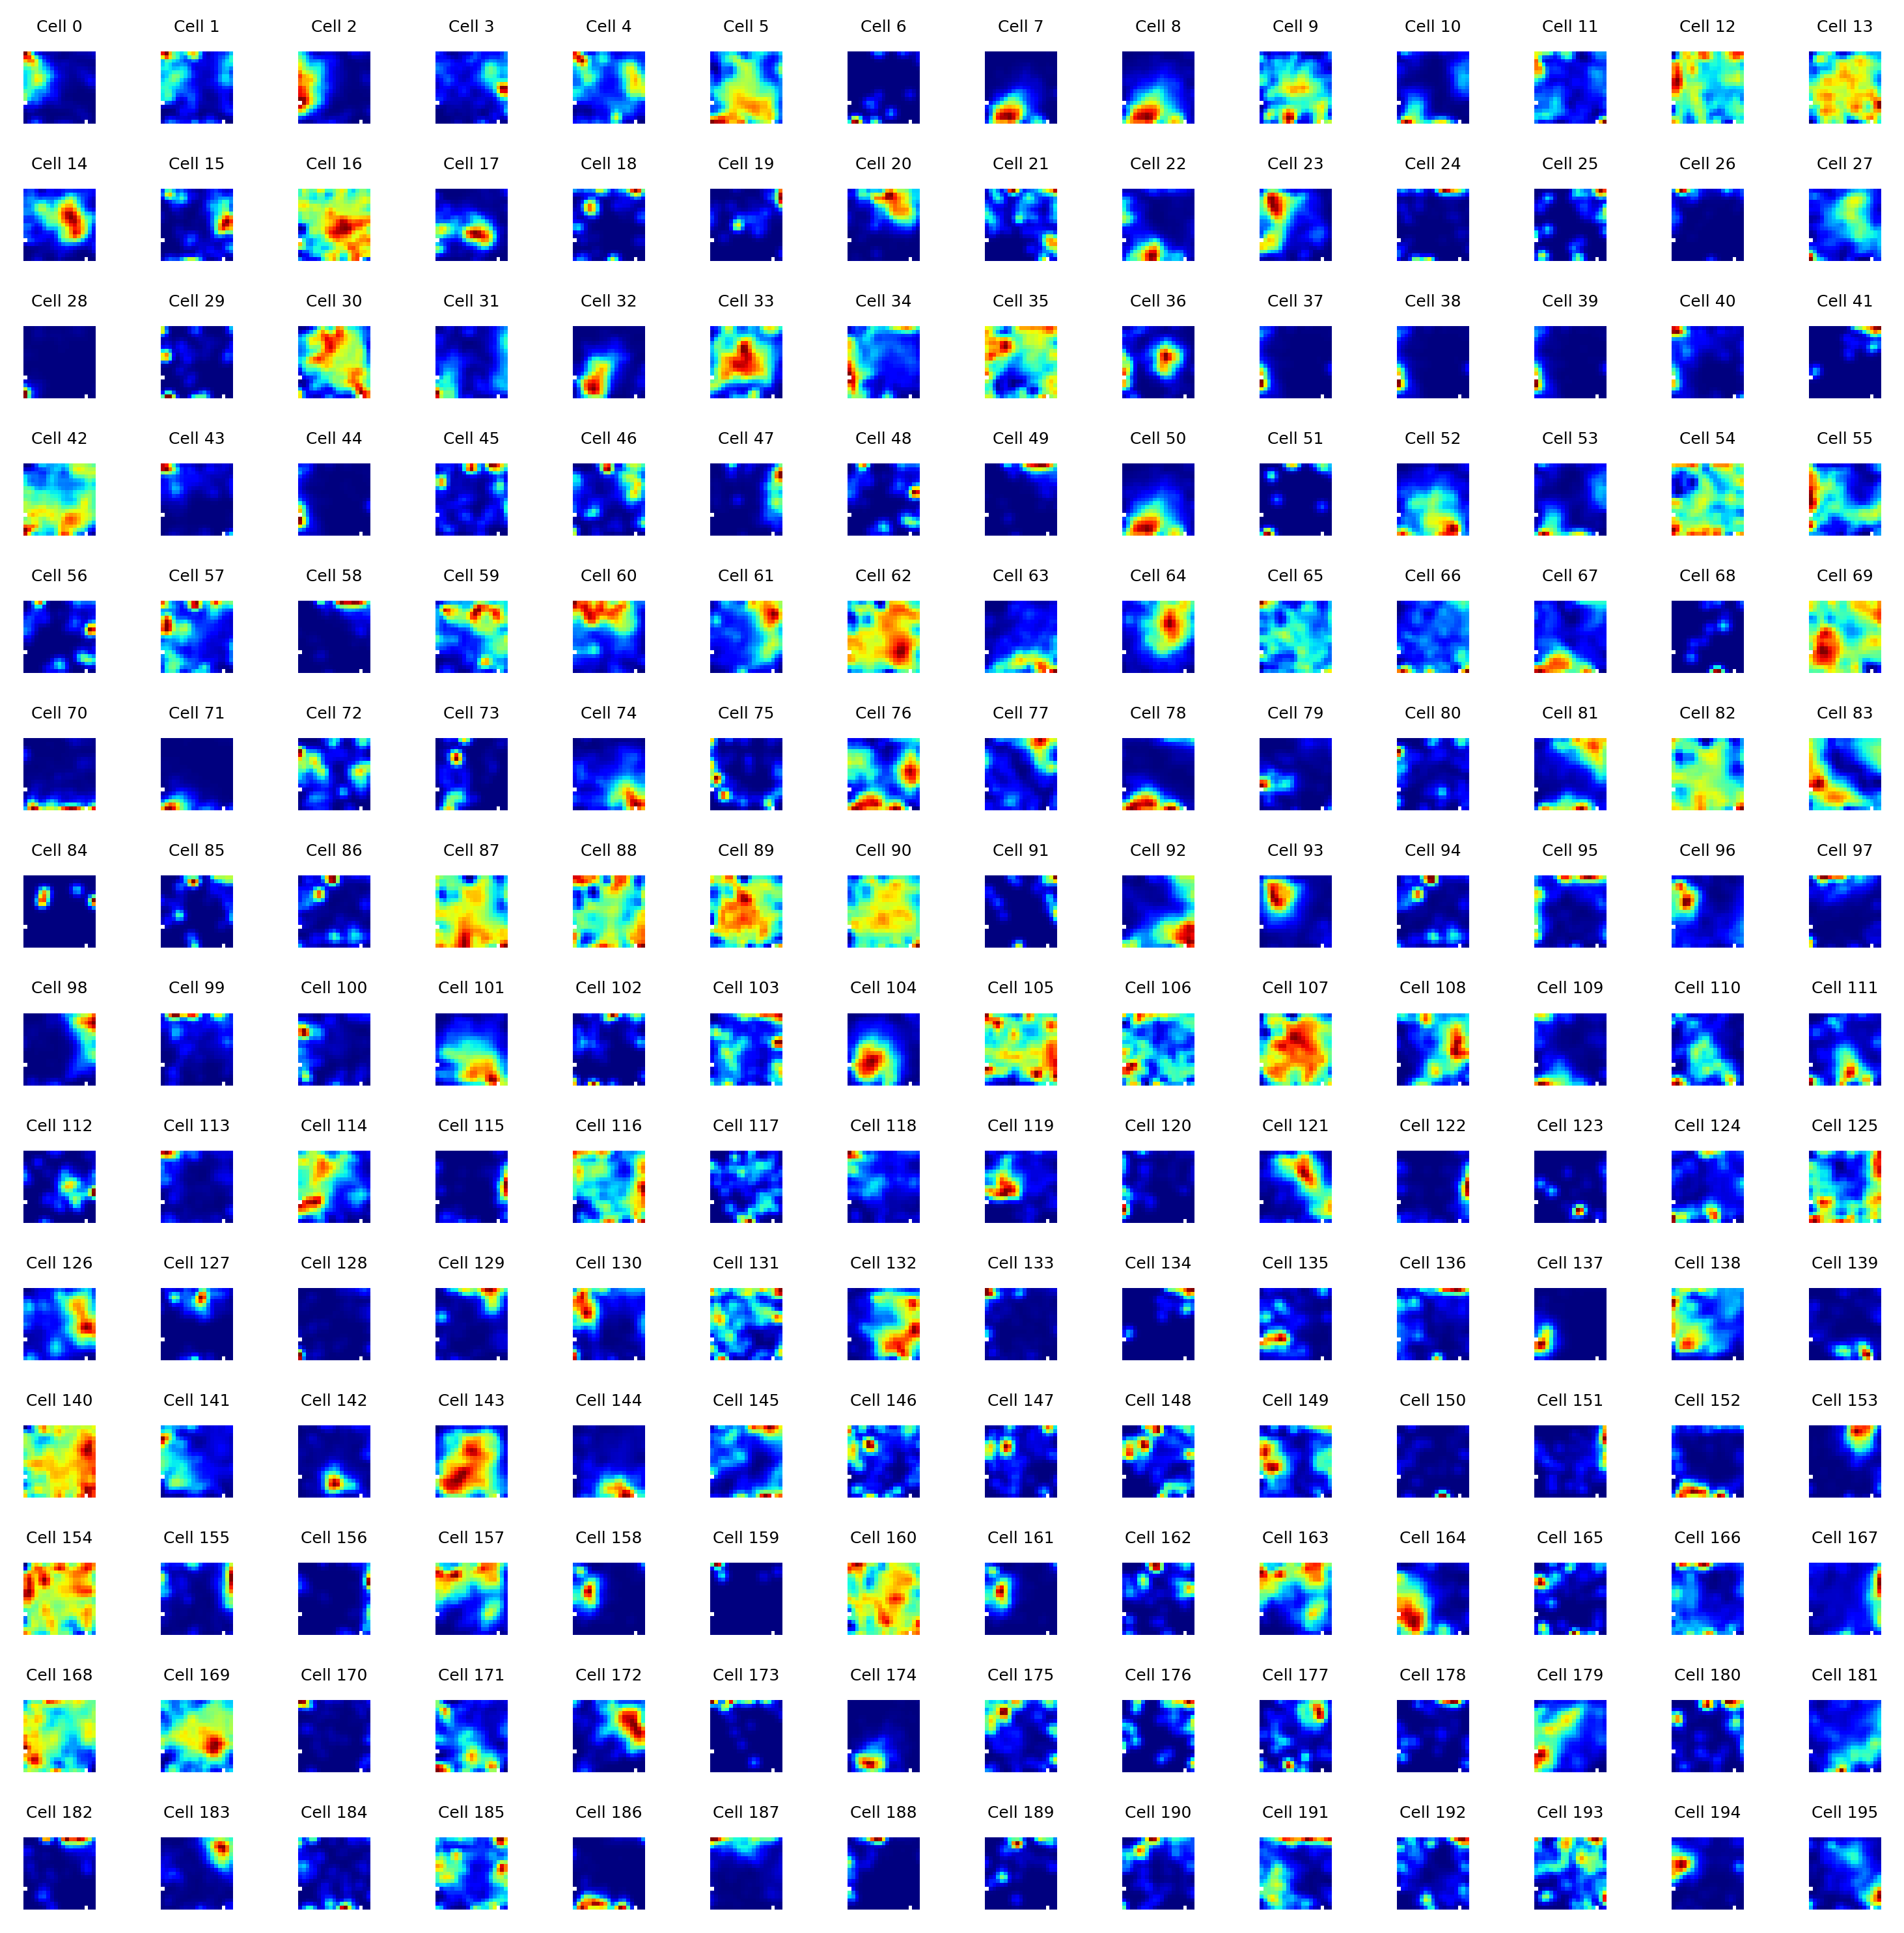

In [8]:
#get the firing fields of all neurons
all_place_fields = decoder.place_fields_.unstack("position").where(environment.is_track_interior_)* pos_sample_rate

num_neurons = SpikeArrays_filered.shape[0]
fig = plt.figure(figsize=(10,10), dpi=300)
labelsize = 10
ticksize = 8

nrows = int(np.ceil(np.sqrt(num_neurons)))
ncols = int(np.ceil(np.sqrt(num_neurons)))

for i in range(num_neurons):
    p_field_i = all_place_fields[i,:,:].values         
    ax = plt.subplot(nrows, ncols, i+1)
    ax.imshow(p_field_i.T, cmap='jet', interpolation='none')
    #gte max firing rate
    max_fr = np.nanmax(p_field_i)
    ax.set_title('Cell %d'%(i), fontsize=ticksize-2)
    ax.axis('off')

#set a suptitle indicating the animal name and trial number
plt.tight_layout()

## predict posterior prob

In [9]:
T = 100000

results = decoder.predict(SpikeArrays_filered.T[:], time=position_times_filtered[:], use_gpu=True) 

  0%|          | 0/196 [00:00<?, ?it/s]

## plot an example trajectory 

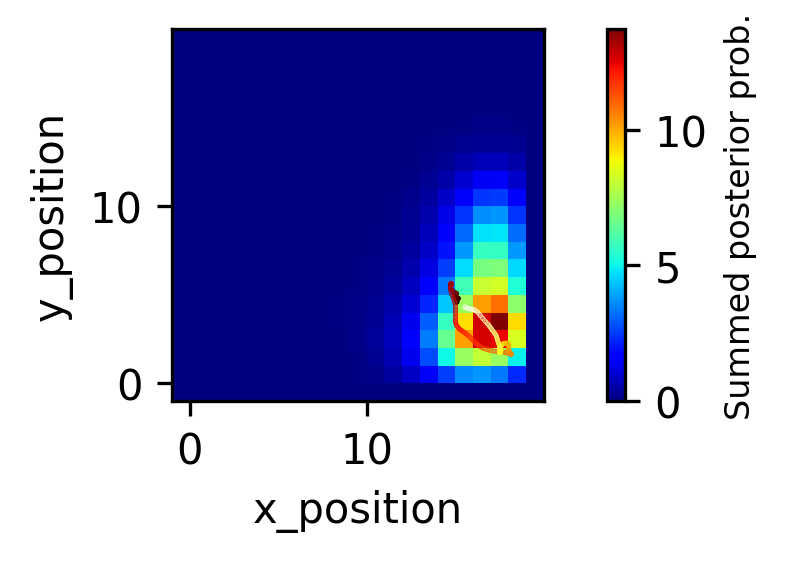

In [10]:
#convert position into a xarray
position_xr = xr.DataArray(position[:T,:], dims=['time', 'position'], coords={'time': position_times_filtered[:T], 'position': ['x', 'y']})
#add x_position and y_position to position_xr, where x_position and y_position are the first and second column of position
position_xr = position_xr.assign_coords(x_position=position_xr[:,0], y_position=position_xr[:,1])

summed_posterior = results.acausal_posterior
max_decode_pos = utils.maximum_a_posteriori_estimate(summed_posterior)

#plot the posterior probability in time range of period
plt.figure(figsize=(2,2), dpi=300)
labelsize = 10
ticksize = 8


#choose a period of time to plot the posterior probability and animal trajectory
#start_time = 1635 #typical example of loop: 1635, 1550
#start_time = 1455 #typical example of triangle: 1455
start_time = 480
duration = 3
period = [start_time, start_time+duration]

#-1 means the last fold
results.acausal_posterior.sel(time=slice(period[0], period[1])).sum('time').transpose('y_position', 'x_position').plot(x='x_position', y='y_position', cmap='jet')
#add the max_decode_pos in the plot
# plt.plot(max_decode_pos.sel(time=slice(period[0], period[1])).x_position, 
#          max_decode_pos.sel(time=slice(period[0], period[1])).y_position, 
#          linewidth=0.2, color='red')
#add the position in the plot
# plt.plot(position_xr.sel(time=slice(period[0], period[1])).x_position, 
#          position_xr.sel(time=slice(period[0], period[1])).y_position, 
#          linewidth=0.2, color='blue')

#do a scatter plot of the max_decode_pos with the time color coded from the colormap of autumn
# plt.scatter(max_decode_pos.sel(time=slice(period[0], period[1])).x_position,
#             max_decode_pos.sel(time=slice(period[0], period[1])).y_position,
#             c=max_decode_pos.sel(time=slice(period[0], period[1])).time,
#             cmap='autumn', s=0.1)
# do a scatter plot of the position with the time color coded from the colormap of winter
plt.scatter(position_xr.sel(time=slice(period[0], period[1])).x_position,
            position_xr.sel(time=slice(period[0], period[1])).y_position,
            c=position_xr.sel(time=slice(period[0], period[1])).time,
            cmap='hot', s=0.01)

# 
#mark the fixed reward location using fixed_reward_xy
#plt.scatter(fixed_reward_xy[0], fixed_reward_xy[1], marker='*', s=20, color='lawngreen')

#equal axis 
plt.gca().set_aspect('equal')
#chnage the colorbar label
plt.gca().collections[0].colorbar.set_label('Summed posterior prob.', fontsize=ticksize)
#get the bottom and the top of the plot image
bottom = plt.gca().get_position().get_points()[0][1]
top = plt.gca().get_position().get_points()[1][1]
#reduce the colorbar length to align with the heiitgh of the plot
plt.gca().collections[0].colorbar.ax.set_position([0.85, bottom, 0.05, top-bottom])

In [10]:

# #convert position into a xarray
# position_xr = xr.DataArray(position[:T,:], dims=['time', 'position'], coords={'time': position_times_filtered[:T], 'position': ['x', 'y']})
# #add x_position and y_position to position_xr, where x_position and y_position are the first and second column of position
# position_xr = position_xr.assign_coords(x_position=position_xr[:,0], y_position=position_xr[:,1])

# summed_posterior = results.acausal_posterior
# max_decode_pos = utils.maximum_a_posteriori_estimate(summed_posterior)

# start_time = 680
# duration = 20
# period = [start_time, start_time+duration]

# # Select time points within the period
# time_slice = position_xr.sel(time=slice(period[0], period[1])).time.values

# # Loop through each time point and generate a frame
# for t in time_slice:
#     fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

#     # Plot posterior at this time
#     posterior_t = results.acausal_posterior.sel(time=t)
#     posterior_t.transpose('y_position', 'x_position').plot(
#         x='x_position', y='y_position', cmap='jet', ax=ax, add_colorbar=False
#     )

#     # Plot animal position at this time
#     pos_t = position_xr.sel(time=t)
#     ax.scatter(pos_t.x_position.values,
#                pos_t.y_position.values,
#                c='red', s=5)

#     ax.set_aspect('equal')
#     ax.set_title(f"Time: {t:.2f}", fontsize=8)
#     ax.axis('off')

#     # Save the frame
#     frame_filename = os.path.join('/home/zilong/Desktop/MattiasDataAnalysis/Results/decoded_frames/', f"frame_{t:.3f}.png")
#     plt.savefig(frame_filename, bbox_inches='tight', pad_inches=0)
#     plt.close(fig)


### make movie for each trajectory

Period from 538.58 to 540.00 seconds: Mean speed = 6.20 units/s
Period from 810.85 to 811.88 seconds: Mean speed = 7.06 units/s
Period from 1081.82 to 1083.10 seconds: Mean speed = 5.59 units/s
Period from 1294.07 to 1295.30 seconds: Mean speed = 7.17 units/s
Period from 1537.32 to 1538.39 seconds: Mean speed = 6.91 units/s
Period from 1574.53 to 1575.69 seconds: Mean speed = 5.71 units/s
Period from 2167.57 to 2169.00 seconds: Mean speed = 6.39 units/s
Period from 4589.39 to 4590.44 seconds: Mean speed = 7.18 units/s
Period from 4788.49 to 4789.96 seconds: Mean speed = 6.15 units/s
Period from 5427.48 to 5429.16 seconds: Mean speed = 7.00 units/s


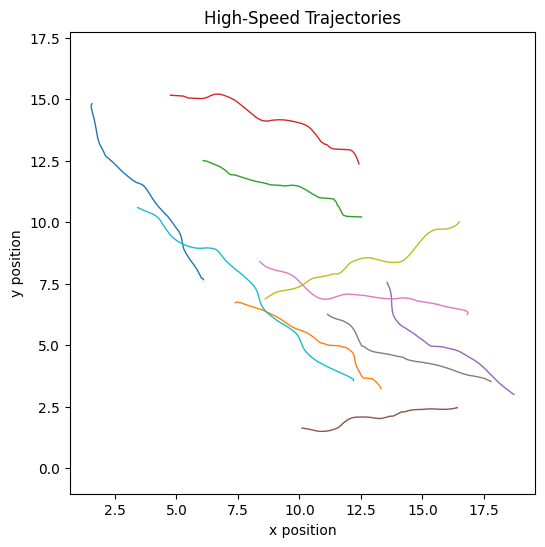

10


In [11]:
#gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

periods = utils.extract_high_speed_periods(speed_filtered_gaussian, position_times_filtered, position, 
                                           speed_thresh=5.0, min_duration=1.,max_angle_std=np.pi/8)

#plot trajectories in high speed periods

plt.figure(figsize=(6, 6))

for start_time, end_time in periods:
    mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    x = position_filtered[0, mask]
    y = position_filtered[1, mask]
    plt.plot(x, y, linewidth=1)
    #print mean speed in each period
    mean_speed = np.mean(speed_filtered[mask])
    print(f"Period from {start_time:.2f} to {end_time:.2f} seconds: Mean speed = {mean_speed:.2f} units/s")

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('High-Speed Trajectories')
plt.axis('equal')
plt.show()
print(len(periods))


In [12]:
# #gaussian smooth speed_filtered
# sigma = 5
# speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

# highspeed_periods = utils.extract_high_speed_periods(speed_filtered_gaussian, position_times_filtered, speed_thresh=4.0, min_duration=1.)

# #convert position into a xarray
# position_xr = xr.DataArray(position, dims=['time', 'position'], coords={'time': position_times_filtered, 'position': ['x', 'y']})
# #add x_position and y_position to position_xr, where x_position and y_position are the first and second column of position
# position_xr = position_xr.assign_coords(x_position=position_xr[:,0], y_position=position_xr[:,1])

# summed_posterior = results.acausal_posterior
# max_decode_pos = utils.maximum_a_posteriori_estimate(summed_posterior)


# for start_time, end_time in highspeed_periods:
    
#     time_slice = position_xr.sel(time=slice(start_time, end_time)).time.values


#     # Loop through each time point and generate a frame
#     for t in time_slice:
#         fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

#         # Plot posterior at this time
#         # posterior_t = results.acausal_posterior.sel(time=t)
#         # posterior_t.plot(
#         #     x='x_position', y='y_position', cmap='jet', ax=ax, add_colorbar=False
#         # )
        
#         posterior_np = results.acausal_posterior.sel(time=t).values
#         ax.imshow(posterior_np.T, origin='lower', cmap='jet')

#         # Plot animal position at this time
#         pos_t = position_xr.sel(time=t)
#         ax.scatter(pos_t.x_position.values,
#                 pos_t.y_position.values,
#                 c='red', s=5)

#         ax.set_aspect('equal')
#         ax.set_title(f"Time: {t:.2f}", fontsize=8)
#         ax.axis('off')

#         # Save the frame
#         frame_filename = os.path.join('/home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/', f"frame_{t:.3f}.png")
#         plt.savefig(frame_filename, bbox_inches='tight', pad_inches=0)
#         plt.close(fig)


In [12]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

output_dir = '/home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/'
os.makedirs(output_dir, exist_ok=True)

#gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

periods = utils.extract_high_speed_periods(speed_filtered_gaussian, position_times_filtered, position, 
                                           speed_thresh=5.0, min_duration=1.,max_angle_std=np.pi/8)

for i, (start_time, end_time) in enumerate(periods):
    start_time -= 1
    end_time += 1
    # Time mask
    time_mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    time_values = position_times_filtered[time_mask]

    # Preload posterior and position
    posterior_block = results.acausal_posterior.sel(time=time_values).values
    position_block = position_filtered[:, time_mask]

    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
    img = ax.imshow(posterior_block[0].T, origin='lower', cmap='jet')
    scatter = ax.scatter(position_block[0, 0], position_block[1, 0], c='red', s=5)
    title = ax.set_title(f"Time: {time_values[0]:.2f}", fontsize=8)
    ax.axis('off')
    ax.set_aspect('equal')

    def update(frame_idx):
        img.set_data(posterior_block[frame_idx].T)
        scatter.set_offsets([position_block[0, frame_idx], position_block[1, frame_idx]])
        title.set_text(f"Time: {time_values[frame_idx]:.2f}")
        return img, scatter, title

    anim = animation.FuncAnimation(
        fig, update, frames=len(time_values), interval=1000 / 15, blit=True
    )

    video_filename = os.path.join(output_dir, f"period_{i:03d}_{start_time:.2f}_{end_time:.2f}.mp4")

    anim.save(video_filename, writer='ffmpeg', fps=15, dpi=150)
    plt.close(fig)
    gc.collect()

    print(f"Saved: {video_filename}")


Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_000_537.58_541.00.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_001_809.85_812.88.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_002_1080.82_1084.10.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_003_1293.07_1296.30.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_004_1536.32_1539.39.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_005_1573.53_1576.69.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_006_2166.57_2170.00.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_007_4588.39_4591.44.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_008_4787.49_4790.96.mp4
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/hig

255
Period from 47.88 to 48.89 seconds: Mean speed = 5.79 units/s
Period from 57.38 to 59.44 seconds: Mean speed = 5.32 units/s
Period from 84.68 to 85.82 seconds: Mean speed = 5.18 units/s
Period from 95.43 to 97.05 seconds: Mean speed = 4.66 units/s
Period from 98.52 to 100.88 seconds: Mean speed = 4.79 units/s
Period from 107.49 to 109.22 seconds: Mean speed = 5.96 units/s
Period from 112.81 to 114.38 seconds: Mean speed = 5.24 units/s
Period from 126.38 to 127.54 seconds: Mean speed = 5.01 units/s
Period from 135.99 to 137.21 seconds: Mean speed = 4.66 units/s
Period from 139.05 to 145.44 seconds: Mean speed = 5.43 units/s
Period from 162.82 to 164.54 seconds: Mean speed = 5.95 units/s
Period from 184.66 to 187.49 seconds: Mean speed = 5.47 units/s
Period from 188.95 to 190.26 seconds: Mean speed = 4.85 units/s
Period from 197.77 to 198.92 seconds: Mean speed = 5.10 units/s
Period from 234.52 to 238.10 seconds: Mean speed = 5.61 units/s
Period from 259.32 to 262.17 seconds: Mean sp

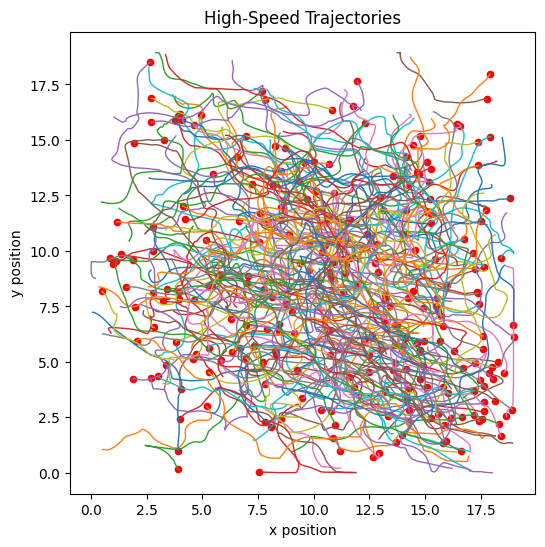

255


In [33]:
output_dir = '/home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/'
os.makedirs(output_dir, exist_ok=True)

#gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

periods = utils.extract_high_speed_periods(speed_filtered_gaussian, position_times_filtered, position, 
                                           speed_thresh=4.0, min_duration=1.,max_angle_std=np.pi/3)

print(len(periods))



plt.figure(figsize=(6, 6))

for start_time, end_time in periods:
    mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    x = position_filtered[0, mask]
    y = position_filtered[1, mask]
    plt.plot(x, y, linewidth=1)
    #print mean speed in each period
    mean_speed = np.mean(speed_filtered[mask])
    print(f"Period from {start_time:.2f} to {end_time:.2f} seconds: Mean speed = {mean_speed:.2f} units/s")
    
    #makr start point as a maker
    plt.scatter(x[0], y[0], marker='o', s=20, color='red')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('High-Speed Trajectories')
plt.axis('equal')
plt.show()
print(len(periods))

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

output_dir = '/home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/'
os.makedirs(output_dir, exist_ok=True)

# Gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest')

periods = utils.extract_high_speed_periods(
    speed_filtered_gaussian, 
    position_times_filtered, 
    position,
    speed_thresh=4.0, 
    min_duration=1.0, 
    max_angle_std=np.pi/3
)

smooth_kernel = 1
labelsize = 6
ticksize = 4

for i, (start_time, end_time) in enumerate(periods):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

    # Time mask
    time_mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    time_values = position_times_filtered[time_mask]

    # Preload posterior and position
    posterior_block = results.acausal_posterior.sel(time=time_values)
    max_pos = utils.maximum_a_posteriori_estimate(posterior_block)

    position_block = position_filtered[:, time_mask]

    # Decoded position
    decoded_x = max_pos.x_position
    decoded_y = max_pos.y_position
    decoded_x = gaussian_filter1d(decoded_x, sigma=smooth_kernel)
    decoded_y = gaussian_filter1d(decoded_y, sigma=smooth_kernel)

    ax.plot(decoded_x, decoded_y, linewidth=0.5, color='#38c7ff', label='Decoded Position', marker='o', markersize=0.5)

    # Actual position
    actual_x = position_block[0, :]
    actual_y = position_block[1, :]
    actual_x = gaussian_filter1d(actual_x, sigma=smooth_kernel)
    actual_y = gaussian_filter1d(actual_y, sigma=smooth_kernel)

    ax.plot(actual_x, actual_y, linewidth=0.5, color='#c738ff', label='Actual Position', marker='o', markersize=0.5)

    ax.set_xlim(0, np.max(position[:, 0]))
    ax.set_ylim(0, np.max(position[:, 1]))
    ax.set_aspect('equal', adjustable='box')
    ax.legend(fontsize=ticksize)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=ticksize)

    plt.tight_layout()

    # Save figure
    fig.savefig(os.path.join(output_dir, f'period_{i:03d}.png'))
    plt.close(fig)
    print(f"Saved: {os.path.join(output_dir, f'period_{i:03d}.png')}")

Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_000.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_001.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_002.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_003.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_004.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_005.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_006.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_007.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_008.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_009.png
Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods_2/period_010.png

In [54]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

output_dir = '/home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/'
os.makedirs(output_dir, exist_ok=True)

#gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

periods = utils.extract_high_speed_periods(
    speed_filtered_gaussian, 
    position_times_filtered, 
    position,
    speed_thresh=4.0, 
    min_duration=1.0, 
    max_angle_std=np.pi/3
)

for i, (start_time, end_time) in enumerate(periods):
    if i != 105:
        continue
    start_time -= 0
    end_time += 0
    # Time mask
    time_mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    time_values = position_times_filtered[time_mask]

    # Preload posterior and position
    posterior_block = results.acausal_posterior.sel(time=time_values).values
    position_block = position_filtered[:, time_mask]

    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
    img = ax.imshow(posterior_block[0].T, origin='lower', cmap='jet')
    scatter = ax.scatter(position_block[0, 0], position_block[1, 0], c='red', s=5)
    title = ax.set_title(f"Time: {time_values[0]:.2f}", fontsize=8)
    ax.axis('off')
    ax.set_aspect('equal')

    def update(frame_idx):
        img.set_data(posterior_block[frame_idx].T)
        scatter.set_offsets([position_block[0, frame_idx], position_block[1, frame_idx]])
        title.set_text(f"Time: {time_values[frame_idx]:.2f}")
        return img, scatter, title

    anim = animation.FuncAnimation(
        fig, update, frames=len(time_values), interval=1000 / 15, blit=True
    )

    video_filename = os.path.join(output_dir, f"period_{i:03d}_{start_time:.2f}_{end_time:.2f}.mp4")

    anim.save(video_filename, writer='ffmpeg', fps=15, dpi=150)
    plt.close(fig)
    gc.collect()

    print(f"Saved: {video_filename}")


Saved: /home/zilong/Desktop/MattiasDataAnalysis/Results/highspeed_periods/period_105_1377.06_1379.71.mp4


In [56]:

# #plot the example filtered signal and the power spectrum
# print(lfp_filtered.shape, position_times_filtered.shape)

lfp_filtered

(583269,) (583269,)


In [26]:
def has_large_jump_or_sharp_turn(max_pos_in_cycle, threshold_distance=3.0, max_angle_change=np.pi/2, smoothing_sigma=1.0):
    """
    Check if there are large jumps or if any successive direction change exceeds a threshold.

    Parameters:
    -----------
    max_pos_in_cycle : xarray.Dataset
        Dataset with variables 'x_position' and 'y_position' over time within the cycle.
    threshold_distance : float
        Maximum allowed distance between successive points (units).
    max_angle_change : float
        Maximum allowed angle change between successive movement vectors (radians).
    smoothing_sigma : float
        Standard deviation for Gaussian smoothing of positions.

    Returns:
    --------
    bool
        True if large jumps or sharp turns are detected.
    """
    x = max_pos_in_cycle.x_position.values
    y = max_pos_in_cycle.y_position.values

    if len(x) < 3:
        # Too few points to check direction properly
        return True

    # Smooth the x and y trajectories
    x_smooth = gaussian_filter1d(x, sigma=smoothing_sigma)
    y_smooth = gaussian_filter1d(y, sigma=smoothing_sigma)

    # Compute successive differences
    dx = np.diff(x_smooth)
    dy = np.diff(y_smooth)
    dists = np.sqrt(dx**2 + dy**2)

    # Check for large jumps
    if np.any(dists > threshold_distance):
        return True

    # Compute movement angles
    movement_angles = np.arctan2(dy, dx)

    # Compute successive changes in movement angles
    angle_diffs = np.diff(movement_angles)

    # Wrap angle differences into [-pi, pi]
    angle_diffs = (angle_diffs + np.pi) % (2 * np.pi) - np.pi

    # Check if any absolute angle change exceeds the threshold
    if np.any(np.abs(angle_diffs) > max_angle_change):
        return True

    return False



/tmp/ipykernel_199991/1636755185.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool')


13 troughs
cycle indenx: 1
cycle indenx: 3
cycle indenx: 5
cycle indenx: 6
cycle indenx: 7
cycle indenx: 8
cycle indenx: 9
cycle indenx: 11
cycle indenx: 12


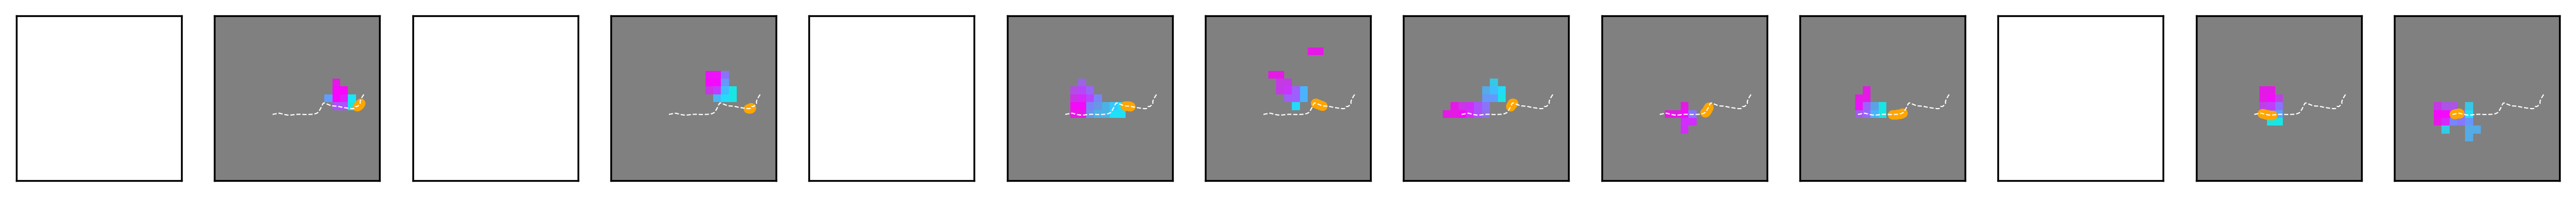

In [96]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
#peak finder package
import scipy.signal as signal
import matplotlib.cm as cm
import matplotlib.colors as mcolors

output_dir = '/home/zilong/Desktop/MattiasDataAnalysis/Results/theta_sweeps/'
os.makedirs(output_dir, exist_ok=True)


lfp_filtered = utils.bandpassfilter(summed_SpikeArray_filtered, lowcut=5, highcut=12, fs=100)

cmap = cm.get_cmap('cool')

#gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

periods = utils.extract_high_speed_periods(
    speed_filtered_gaussian, 
    position_times_filtered, 
    position,
    speed_thresh=4.0, 
    min_duration=1.0, 
    max_angle_std=np.pi/3
)

for i, (start_time, end_time) in enumerate(periods):
    # if i < 210 or i > 270:
    # if i > 70:
        # continue
    if i != 127:
        continue
    start_time -= 0
    end_time += 0
    # Time mask
    time_mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    time_block = position_times_filtered[time_mask]
    time_values = position_times_filtered[time_mask]
    
    lfp_filtered_block = lfp_filtered[time_mask]    
    summed_SpikeArray_filtered_block = summed_SpikeArray_filtered[time_mask]
    
    fig, ax = plt.subplots(1,1, figsize=(8, 2), dpi=300)
    
    #plot summed_SpikeArray_filtered_block vs time_values using bar plot
    ax.bar(time_block-time_block[0], summed_SpikeArray_filtered_block, width=0.01, color='black', alpha=0.6)
    
    #Add filtered lfp signal to the plot
    ax.plot(time_block-time_block[0], lfp_filtered_block+20, color='deepskyblue', linewidth=0.5, alpha=1)
    #set x ticks as only integer
    ax.set_xticks(np.arange(0, np.ceil(time_block[-1]-time_block[0]), 1))
    #ylabels as spikes
    ax.set_ylabel('spikes')
    
    sns.despine()

    #next check how many theta cycles are in the period, calculate as trough to trough of lfp_filtered
    #find the troughs of the lfp_filtered
    troughs = signal.find_peaks(-lfp_filtered_block)[0]
    
    #mark the troughs in the plot
    ax.scatter(time_block[troughs]-time_block[0], lfp_filtered_block[troughs]+20, color='red', s=1)

    
    troughs = troughs
    num_cycles = len(troughs)-1
    print(f"{num_cycles} troughs")
    
    ylim = ax.get_ylim()
    #add vertical lines to the plot from 15th to 22th trough
    ax.vlines(time_block[troughs[0]]-time_block[0], ymin=0, ymax=ylim[1], color='black', lw=1, linestyle='--') 
    ax.vlines(time_block[troughs[-1]]-time_block[0], ymin=0, ymax=ylim[1], color='black', lw=1, linestyle='--')
    
    #save the figure
    fig.savefig(os.path.join(output_dir, f'lfp_period_{i:03d}.png'))
    #close the figure
    plt.close(fig)
    
    fig, axs = plt.subplots(1,num_cycles, figsize=(20, 2), dpi=300)
    #plot the max decode position in each cycle
    # Preload posterior and position
    position_block = position_filtered[:, time_mask]
    
    posterior_block = results.acausal_posterior.sel(time=time_values)
    max_pos = utils.maximum_a_posteriori_estimate(posterior_block)

    for j in range(num_cycles):
        ax_j = axs[j]

        # Plot the animal's trajectory as dashed line
        ax_j.plot(position_block[0, :], position_block[1, :], color='white', lw=0.5, linestyle='--')

        # Time indices for this theta cycle
        start_idx = troughs[j]
        end_idx = troughs[j+1]
        
        # Plot the maximum decoded trajectory
        max_pos_in_cycle = max_pos.sel(time=time_block[start_idx:end_idx])
        # ax_j.plot(max_pos_in_cycle.x_position, max_pos_in_cycle.y_position, color='red', lw=0.5)        

        #perform filtering here
        #criterion 1 max_pos_in_cycle successive pos should not be more than 3 to remove jumps
        flag = has_large_jump_or_sharp_turn(max_pos_in_cycle, threshold_distance=3.0, max_angle_change=np.pi/2, smoothing_sigma=3.0)
        if flag:
            print(f"Cycle {j} has large jumps or total turns larger than threshold.")
            continue
        #criteria 2: select the longest period, from the cloest to actual position and the farest to actual position
        #calculate the distance between max_pos_in_cycle and actual position
        dist = np.sqrt((max_pos_in_cycle.x_position.values - position_block[0, start_idx:end_idx])**2 +
                       (max_pos_in_cycle.y_position.values - position_block[1, start_idx:end_idx])**2)
        # Find the index of the minimum and maximum distance
        idx_min = np.argmin(dist)
        idx_max = np.argmax(dist)

        # Ensure idx_min < idx_max and dist max - min > 5
        if idx_min > idx_max:
            continue
        if dist[idx_max] - dist[idx_min] < 1:
            continue

        # Select only the segment between idx_min and idx_max
        time_indices = np.arange(idx_min, idx_max + 1)

        print('cycle indenx:', j)
        if j==21:
            aa=1
        # Posterior in cycle
        posterior_values = posterior_block.sel(time=time_block[start_idx:end_idx]).values  # shape (T, 21, 21)

        for cidx, t in enumerate(time_indices):
            posterior_frame = posterior_values[t, :, :]  # (21, 21)

            # Mask: keep top 10%
            valid_vals = posterior_frame[~np.isnan(posterior_frame)].flatten()
            if valid_vals.size == 0:
                continue
            sorted_vals = np.sort(valid_vals)
            threshold_idx = int(0.99 * len(sorted_vals))
            threshold_val = sorted_vals[threshold_idx]

            posterior_display = np.full_like(posterior_frame, np.nan)
            mask = posterior_frame >= threshold_val
            posterior_display[mask] = posterior_frame[mask]

            # Get colour corresponding to this timepoint
            colour = cmap(cidx / (len(time_indices) - 1))  # Normalise t to [0, 1]

            # Plot
            ax_j.imshow(
                posterior_display.T,   # Transpose to match axis convention
                origin='lower',
                extent=[0, np.max(position[:, 0]), 0, np.max(position[:, 1])],
                cmap=mcolors.ListedColormap([colour]),  # Force single colour
                vmin=0, vmax=1,
                alpha=0.8
            )

        # Plot the maximum decoded trajectory
        max_pos_in_cycle = max_pos.sel(time=time_block[start_idx:end_idx])
        # ax_j.plot(max_pos_in_cycle.x_position, max_pos_in_cycle.y_position, color='red', lw=0.5)
        #add actual position in the
        ax_j.scatter(position_block[0, start_idx:end_idx], position_block[1, start_idx:end_idx], 
                    color='orange', s=10, alpha=1)
        
        ax_j.set_facecolor('grey')

    for ax in axs:
        # Format
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_xlim(0, np.max(position[:, 0]))
        ax.set_ylim(0, np.max(position[:, 1]))
        

    # Save figure
    fig.savefig(os.path.join(output_dir, f'sweeps_period_{i:03d}.png'))
    #close the figure
    # plt.close(fig)
    


/tmp/ipykernel_199991/542832171.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cool')


4 troughs
cycle indenx: 0
cycle indenx: 1
cycle indenx: 2
cycle indenx: 3


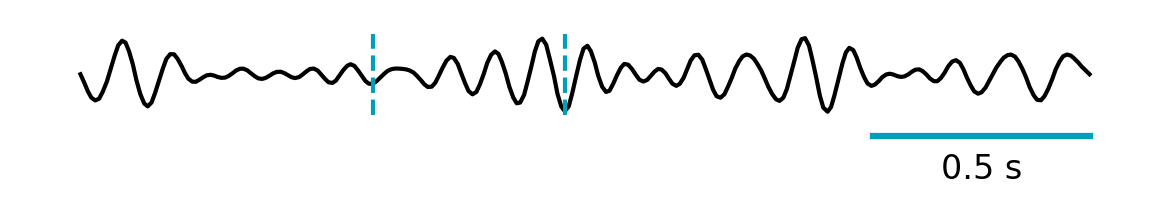

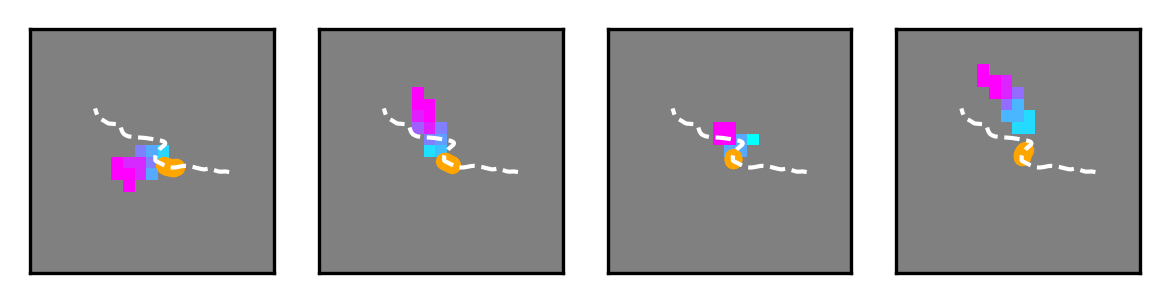

In [138]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
#peak finder package
import scipy.signal as signal
import matplotlib.cm as cm
import matplotlib.colors as mcolors

output_dir = '/home/zilong/Desktop/MattiasDataAnalysis/Results/theta_sweeps_selected/'
os.makedirs(output_dir, exist_ok=True)


lfp_filtered = utils.bandpassfilter(summed_SpikeArray_filtered, lowcut=5, highcut=12, fs=100)

cmap = cm.get_cmap('cool')

#gaussian smooth speed_filtered
sigma = 20
speed_filtered_gaussian = gaussian_filter1d(speed_filtered, sigma=sigma, mode='nearest') 

periods = utils.extract_high_speed_periods(
    speed_filtered_gaussian, 
    position_times_filtered, 
    position,
    speed_thresh=4.0, 
    min_duration=1.0, 
    max_angle_std=np.pi/3
)

for i, (start_time, end_time) in enumerate(periods):
    # 64: 7-12 cycles
    # 110: 5-10 cycles
    # 117: 4-9
    # 120: 12-17
    # 155: 12-17
    # 168: 12-17
    # 127: 5-10
    # 92: 1-6
    if i != 64:
        continue
    start_time -= 0
    end_time += 0
    # Time mask
    time_mask = (position_times_filtered >= start_time) & (position_times_filtered <= end_time)
    time_block = position_times_filtered[time_mask]
    time_values = position_times_filtered[time_mask]
    
    lfp_filtered_block = lfp_filtered[time_mask]    
    summed_SpikeArray_filtered_block = summed_SpikeArray_filtered[time_mask]
    
    fig, ax = plt.subplots(1,1, figsize=(4, 1.2), dpi=300)
    
    #plot summed_SpikeArray_filtered_block vs time_values using bar plot
    # ax.bar(time_block-time_block[0], summed_SpikeArray_filtered_block, width=0.01, color='black', alpha=0.6)
    
    #Add filtered lfp signal to the plot
    ax.plot(time_block-time_block[0], lfp_filtered_block, color='black', linewidth=1, alpha=1)
    #set x ticks as only integer
    ax.set_xticks(np.arange(0, np.ceil(time_block[-1]-time_block[0]), 1))
    #ylabels as spikes
    # ax.set_ylabel('spikes', fontsize=10)
    ax.set_xlabel('time (s)', fontsize=10)
    #x y tick font size as 8
    ax.tick_params(axis='both', which='major', labelsize=8)
    #y axis off
    ax.axis('off')
    ax.spines['bottom'].set_visible(True)
        
    sns.despine()

    #next check how many theta cycles are in the period, calculate as trough to trough of lfp_filtered
    #find the troughs of the lfp_filtered
    troughs = signal.find_peaks(-lfp_filtered_block)[0]
    
    #mark the troughs in the plot
    # ax.scatter(time_block[troughs]-time_block[0], lfp_filtered_block[troughs]+20, color='red', s=1)

    
    troughs = troughs[7:12]
    num_cycles = len(troughs)-1
    print(f"{num_cycles} troughs")
    
    ylim = ax.get_ylim()
    #add vertical lines to the plot from 15th to 22th trough
    ax.vlines(time_block[troughs[0]]-time_block[0], ymin=ylim[0], ymax=ylim[1], color='#009FB9', lw=1, linestyle='--') 
    ax.vlines(time_block[troughs[-1]]-time_block[0], ymin=ylim[0], ymax=ylim[1], color='#009FB9', lw=1, linestyle='--')
    
    # Add a 0.5 second time scale bar manually
    scalebar_x = time_block[-1] - time_block[0] -0.5  # 0.1 seconds from the left (adjust as needed)
    scalebar_y = ylim[0]*1.5  # 5% above the bottom (adjust as needed)

    # Plot the horizontal line
    ax.plot([scalebar_x, scalebar_x + 0.5], [scalebar_y, scalebar_y], color='#009FB9', lw=1.5)

    # Optionally add a label
    ax.text(scalebar_x + 0.25, scalebar_y - 0.2*(ylim[1]-ylim[0]), '0.5 s',
            ha='center', va='top', fontsize=8)
    
    
    plt.tight_layout()
    #save the figure
    fig.savefig(os.path.join(output_dir, f'lfp_period_{i:03d}.pdf'))
    #close the figure
    # plt.close(fig)
    
    fig, axs = plt.subplots(1,num_cycles, figsize=(4, 1.5), dpi=300)
    #plot the max decode position in each cycle
    # Preload posterior and position
    position_block = position_filtered[:, time_mask]
    
    posterior_block = results.acausal_posterior.sel(time=time_values)
    max_pos = utils.maximum_a_posteriori_estimate(posterior_block)

    for j in range(num_cycles):
        ax_j = axs[j]

        # Plot the animal's trajectory as dashed line
        ax_j.plot(position_block[0, :], position_block[1, :], color='white', lw=1, linestyle='--')

        # Time indices for this theta cycle
        start_idx = troughs[j]
        end_idx = troughs[j+1]
        
        # Plot the maximum decoded trajectory
        max_pos_in_cycle = max_pos.sel(time=time_block[start_idx:end_idx])
        # ax_j.plot(max_pos_in_cycle.x_position, max_pos_in_cycle.y_position, color='red', lw=0.5)        

        #perform filtering here
        #criterion 1 max_pos_in_cycle successive pos should not be more than 3 to remove jumps
        # flag = has_large_jump_or_sharp_turn(max_pos_in_cycle, threshold_distance=3.0, max_angle_change=np.pi/2, smoothing_sigma=3.0)
        # if flag:
        #     print(f"Cycle {j} has large jumps or total turns larger than threshold.")
        #     continue
        #criteria 2: select the longest period, from the cloest to actual position and the farest to actual position
        #calculate the distance between max_pos_in_cycle and actual position
        dist = np.sqrt((max_pos_in_cycle.x_position.values - position_block[0, start_idx:end_idx])**2 +
                       (max_pos_in_cycle.y_position.values - position_block[1, start_idx:end_idx])**2)
        # Find the index of the minimum and maximum distance
        idx_min = np.argmin(dist)
        idx_max = np.argmax(dist)

        # # Ensure idx_min < idx_max and dist max - min > 5
        # if idx_min > idx_max:
        #     continue
        # if dist[idx_max] - dist[idx_min] < 1:
        #     continue

        # Select only the segment between idx_min and idx_max
        time_indices = np.arange(idx_min, idx_max + 1)

        print('cycle indenx:', j)

        # Posterior in cycle
        posterior_values = posterior_block.sel(time=time_block[start_idx:end_idx]).values  # shape (T, 21, 21)

        for cidx, t in enumerate(time_indices):
            posterior_frame = posterior_values[t, :, :]  # (21, 21)

            # Mask: keep top 10%
            valid_vals = posterior_frame[~np.isnan(posterior_frame)].flatten()
            if valid_vals.size == 0:
                continue
            sorted_vals = np.sort(valid_vals)
            threshold_idx = int(0.99 * len(sorted_vals))
            threshold_val = sorted_vals[threshold_idx]

            posterior_display = np.full_like(posterior_frame, np.nan)
            mask = posterior_frame >= threshold_val
            posterior_display[mask] = posterior_frame[mask]

            # Get colour corresponding to this timepoint
            colour = cmap(cidx / (len(time_indices) - 1))  # Normalise t to [0, 1]

            # Plot
            ax_j.imshow(
                posterior_display.T,   # Transpose to match axis convention
                origin='lower',
                extent=[0, np.max(position[:, 0]), 0, np.max(position[:, 1])],
                cmap=mcolors.ListedColormap([colour]),  # Force single colour
                vmin=0, vmax=1,
                alpha=1.0
            )

        # Plot the maximum decoded trajectory
        max_pos_in_cycle = max_pos.sel(time=time_block[start_idx:end_idx])
        # ax_j.plot(max_pos_in_cycle.x_position, max_pos_in_cycle.y_position, color='red', lw=0.5)
        #add actual position in the
        ax_j.scatter(position_block[0, start_idx:end_idx], position_block[1, start_idx:end_idx], 
                    color='orange', s=10, alpha=1)
        
        

    for ax in axs:
        # Format
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_xlim(0, np.max(position[:, 0]))
        ax.set_ylim(0, np.max(position[:, 1]))
        ax.set_facecolor('grey')
        
    plt.tight_layout()
        

    # Save figure
    fig.savefig(os.path.join(output_dir, f'sweeps_period_{i:03d}.pdf'))
    #close the figure
    # plt.close(fig)
    
